# Phase 2: Modeling and Explainability

This notebook follows the exploratory data analysis (EDA) and focuses on modeling, evaluation, and interpretability. 
The main objectives are:

1. **Cluster-based profiling** of tourists according to trip characteristics and expenditure patterns.  
2. **Prediction of key variables** such as daily average expenditure and trip length.  
3. **Explainability using SHAP values**, to make the models transparent and suitable for reporting in the chatbot-based system.  

The prepared dataset (`egatur_data_ready.csv`) created in the EDA phase will be the starting point. 

In [1]:
# ===============================
# 1. Setup & Data Loading
# ===============================
import pandas as pd
import numpy as np
from pathlib import Path

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import seaborn as sns
from adjustText import adjust_text
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Explainability
import shap

# Saving
import joblib

# Paths
DATA_DIR = Path("../data/processed")
df = pd.read_csv(DATA_DIR / "egatur_data_ready.csv")

df.head()

,daily_average_expenditure,trip_length,accommodation,purpose,season,country,region,cluster
0,129.318995,14,Non-market,Leisure/holidays,winter,Occident and America,Valencian Community,0
1,127.224771,16,Non-market,Leisure/holidays,winter,Occident and America,Valencian Community,0
2,273.413983,9,Hotels and similar,Leisure/holidays,winter,Occident and America,Madrid,3
3,111.493501,27,Non-market,Leisure/holidays,winter,Occident and America,Valencian Community,0
4,124.846663,14,Non-market,Other,winter,Occident and America,Canary Islands,2


## 2. Data Preparation

The dataset contains both numerical and categorical variables.  
For modeling purposes, we will:
- Scale numerical variables (`daily_average_expenditure_log`, `trip_length_log`).
- Encode categorical variables (`accommodation`, `purpose`, `season`, `country`, `region`).
- Separate target variables for supervised models.

In [2]:
# Features and targets
features = ["accommodation", "purpose", "season", "country", "region",
            "daily_average_expenditure", "trip_length"]

target_expenditure = "daily_average_expenditure"
target_trip_length = "trip_length"

X = df[features]
y_expenditure = df[target_expenditure]
y_trip_length = df[target_trip_length]

# Preprocessing pipeline
numeric_features = ["daily_average_expenditure", "trip_length"]
categorical_features = ["accommodation", "purpose", "season", "country", "region"]

# Transformer: log(1+x) to avoid log(0)
def log_transform(x):
    return np.log1p(x)
log_transformer = FunctionTransformer(log_transform, validate=False)

numeric_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore",
                             categories=[df[col].unique() for col in categorical_features])),
    ("scaler", StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

## 3. Clustering with classificator

We apply KMeans to identify homogeneous groups of tourists.  
The optimal number of clusters can be selected based on inertia and silhouette score, 
but here we reuse `k=4` for interpretability, as identified in the EDA.

 **Note**: The clusters obtained from this pipeline may differ slightly from those
 observed in the original EDA. This is due to differences in preprocessing:
 - In the pipeline, numerical features are log-transformed and standardized,
   and categorical features are one-hot encoded and scaled to balance their weight.
 - In the EDA, the preprocessing may have been slightly different (e.g., manual
   concatenation of log-transformed numeric columns and dummies scaled together),
   which affects the KMeans distance calculations.

Despite these minor differences, the overall cluster structure and interpretation remain consistent with the original analysis.

In [3]:
kmeans = Pipeline(steps=[("preprocessor", preprocessor),
                         ("clusterer", KMeans(n_clusters=4, random_state=42))])

clusters = kmeans.fit_predict(X)
df["cluster_pred"] = clusters

# Save clustering model
joblib.dump(kmeans, "../models/kmeans_tourists.joblib")

df[["cluster_pred"]].value_counts()

cluster_pred
0               102516
1                81138
2                45496
3                 6638
Name: count, dtype: int64

cluster_pred
0    102516
1     81138
2     45496
3      6638
Name: count, dtype: int64

Numerical variables (mean) by cluster:


,daily_average_expenditure,trip_length
cluster_pred,,
0,221.581436,6.473858
1,124.753316,14.579815
2,461.298880,5.643199
3,203.419491,4.560560



Top categorical combinations per cluster:


,cluster_pred,accommodation,purpose,season,country,region,proportion
0,0,Hotels and similar,Leisure/holidays,summer,Occident and America,Balearic Islands,0.099204
1,0,Hotels and similar,Leisure/holidays,winter,Occident and America,Canary Islands,0.069716
2,0,Hotels and similar,Leisure/holidays,spring,Occident and America,Canary Islands,0.060195
3,1,Non-market,Leisure/holidays,summer,Occident and America,Valencian Community,0.035421
4,1,Non-market,Leisure/holidays,summer,Occident and America,Andalusia,0.029062
5,1,Non-market,Leisure/holidays,autumn,Occident and America,Valencian Community,0.027866
6,2,Hotels and similar,Leisure/holidays,summer,Russia + Rest of the world,Catalonia,0.057829
7,2,Hotels and similar,Leisure/holidays,autumn,Russia + Rest of the world,Catalonia,0.048752
8,2,Hotels and similar,Leisure/holidays,summer,Russia + Rest of the world,Madrid,0.041322
9,3,Hotels and similar,Leisure/holidays,summer,United Kingdom,Balearic Islands,0.048509


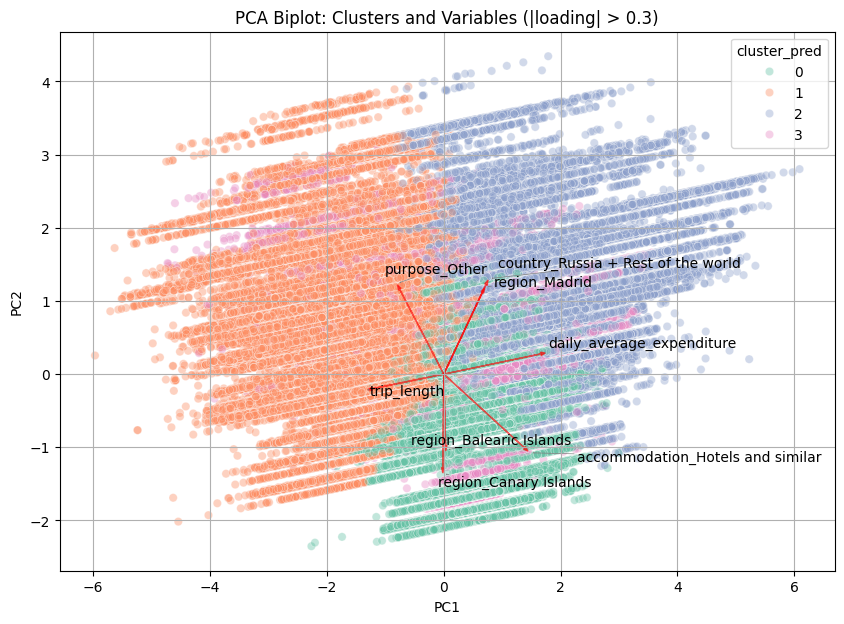

In [6]:
#### Display number of samples per cluster ####
print(df["cluster_pred"].value_counts())

#### Summary of numerical variables by cluster ####
num_summary = df.groupby("cluster_pred")[["daily_average_expenditure", "trip_length"]].mean()
print("\nNumerical variables (mean) by cluster:")
display(num_summary)

#### Top 5 categorical combinations per cluster ####
top_cat = (
    df.groupby("cluster_pred")[categorical_features]
      .value_counts(normalize=True)
      .rename("proportion")
      .groupby(level=0, group_keys=False)
      .nlargest(3)
      .reset_index()
)
print("\nTop categorical combinations per cluster:")
display(top_cat)

#### PCA for visualization ####
# Standardize numeric + one-hot encode categorical
X_processed = preprocessor.fit_transform(X)

# Scale for PCA
scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse after OneHot
X_scaled = scaler.fit_transform(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Get loadings (variable contributions to PCs)
feature_names = (
    numeric_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

# Filter loadings (only strong contributions)
mask = (loadings.abs() > 0.3).any(axis=1)
loadings_filtered = loadings[mask]

# --- Plot ---
plt.figure(figsize=(10,7))

# Scatter plot of clusters in PCA space
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df["cluster_pred"], palette="Set2", alpha=0.4
)

texts = []
for var in loadings_filtered.index:
    plt.arrow(0, 0,
              loadings_filtered.loc[var, "PC1"]*3,
              loadings_filtered.loc[var, "PC2"]*3,
              color="red", alpha=0.6, head_width=0.05)
    texts.append(
        plt.text(loadings_filtered.loc[var, "PC1"]*3.2,
                 loadings_filtered.loc[var, "PC2"]*3.2,
                 var, color="black")
    )

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot: Clusters and Variables (|loading| > 0.3)")
plt.grid(True)
plt.show()

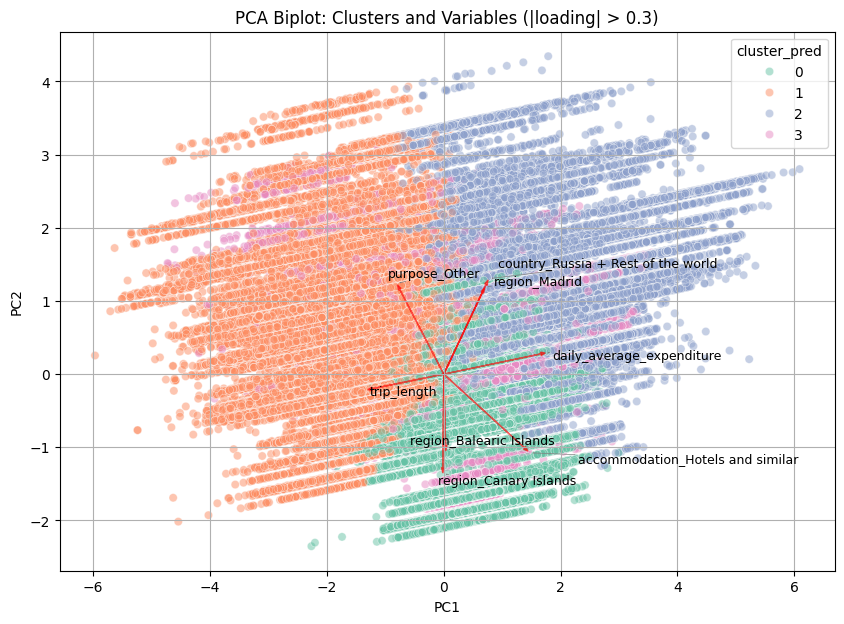

In [5]:
# --- PCA for visualization ---
# Standardize numeric + one-hot encode categorical
X_processed = preprocessor.fit_transform(X)

# Scale for PCA
scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse after OneHot
X_scaled = scaler.fit_transform(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Get loadings (variable contributions to PCs)
feature_names = (
    numeric_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

# Filter loadings (only strong contributions)
mask = (loadings.abs() > 0.3).any(axis=1)
loadings_filtered = loadings[mask]

# --- Plot ---
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df["cluster_pred"], palette="Set2", alpha=0.5
)

# Add variable loadings arrows
texts = []
for var in loadings_filtered.index:
    plt.arrow(0, 0,
              loadings_filtered.loc[var, "PC1"]*3,
              loadings_filtered.loc[var, "PC2"]*3,
              color="red", alpha=0.6, head_width=0.05)
    texts.append(
        plt.text(loadings_filtered.loc[var, "PC1"]*3.2,
                 loadings_filtered.loc[var, "PC2"]*3.2,
                 var, color="black", fontsize=9)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot: Clusters and Variables (|loading| > 0.3)")
plt.grid(True)
plt.show()


## 4. Supervised Regression Models

We train models to predict:
1. Daily average expenditure (`y_expenditure`)
2. Trip length (`y_trip_length`)

Three models will be tested:
- Linear Regression (baseline)
- Random Forest Regressor
- Gradient Boosting Regressor


### Linear Regression

#### Expenditure

In [ ]:
# Define targets
targets = {
    "expenditure": "daily_average_expenditure",
    "trip_length": "trip_length"
}

# Define models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

for target_name, target_col in targets.items():
    y = df[target_col]
    X = df[features]

    for model_name, model in models.items():
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),  # same preprocessor as before
            ("regressor", model)
        ])

        scores = cross_validate(
            pipe,
            X, y,
            cv=cv,
            scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
            return_train_score=False
        )

        results.append({
            "target": target_name,
            "model": model_name,
            "R2_mean": np.mean(scores["test_r2"]),
            "MAE_mean": -np.mean(scores["test_neg_mean_absolute_error"]),
            "RMSE_mean": -np.mean(scores["test_neg_root_mean_squared_error"])
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

#### Trip Length

### Random Forest

#### Expenditure

#### Trip Length

### Gradient Boosting

#### Expenditure

#### Trip Length

## 5. Explainability with SHAP

We use SHAP to explain the predictions of the best-performing model.  
This allows us to identify which features contribute most to expenditure prediction, 
both globally (feature importance) and locally (individual tourist profiles).

## 6. Reporting Insights

With the models trained and saved, we can now:
- Assign new tourists to a cluster.
- Predict expenditure and trip length.
- Explain predictions with SHAP values.  

These elements will feed into the **MCP report server**, 
where the chatbot can generate dynamic reports for end-users.
